In [6]:
import numpy as np
import os
import pandas as pd
import sys

# Config

In [21]:
HYPER_OPT = True 
HYPER_OPT_TIME = 60
USE_ORIGINAL_DATA = False 
SUBMIT_TO_KAGGLE = False
COMPUTE_NONLOG = False
USE_NONLOG = True

In [8]:
# Define the base directory (where the notebook is running)
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
data_dir = os.path.join(base_dir, "data")
model_dir = os.path.join(base_dir, "models")
notebooks_dir = os.path.join(base_dir, "notebooks")
sys.path.append(base_dir)

# Data Extraction

In [9]:
from axyom_utilities.data_extraction import extract_data
from axyom_utilities.training import train_model_cv
from axyom_utilities.preprocessing import * 
from toolz import pipe
import joblib

# oof_log = pd.read_csv(os.path.join(notebooks_dir, "Catboost_nonlog\\oof_preds_log.csv"))
# oof_nonlog = pd.read_csv(os.path.join(notebooks_dir, "Catboost_nonlog\\oof_preds_nonlog.csv"))

# test_log = pd.read_csv(os.path.join(notebooks_dir, "Catboost_nonlog\\test_preds_log.csv"))
# test_nonlog = pd.read_csv(os.path.join(notebooks_dir, "Catboost_nonlog\\test_preds_nonlog.csv"))

# X_train["oof_nonlog"] = oof_nonlog + np.random.normal(0, 0.01, oof_log.shape) # noise
# X_test["oof_nonlog"] = test_nonlog + np.random.normal(0, 0.01, oof_log.shape)

# X_test["oof_log"] = test_log
# X_train["oof_log"] = oof_log

In [10]:
X_train, y_train, X_test, X_orig, y_orig = extract_data(data_dir, USE_ORIGINAL_DATA, log_transform=True)
y_train_nonlog = np.expm1(y_train)

if USE_NONLOG:
    if COMPUTE_NONLOG:
        nonlog_oof_preds, nonlog_test_preds = get_oof(X_train, y_train_nonlog, X_test)
    else:
        nonlog_oof_preds, nonlog_test_preds = joblib.load('nonlog_feature/cat_non_loged.pkl')
    
    X_train["nonlog"] = nonlog_oof_preds
    X_test["nonlog"] = nonlog_test_preds

# Data Cleaning

In [ ]:
from axyom_utilities.preprocessing import freq_encode, preprocess_dates, clean_categorical, frequency_encode
from toolz import pipe

def feature_engineering(df):
    
    # df = freq_encode(df)
    
    df['MissingHealth'] = df['Health Score'].isna().astype(int)
    df['Claims v Duration'] = (df['Previous Claims'] / df['Insurance Duration']).replace([np.inf, -np.inf], np.nan)
    df['Health vs Claims'] = (df['Health Score'] / df['Previous Claims']).replace([np.inf, -np.inf], np.nan)
    
    def duplicate_int(col, df):
        df[col + ' Integer'] = df[col].apply(lambda x: int(x) if pd.notna(x) else x)
        #df[col] = df[col].fillna('None').astype('category')
        
        return df
    
    df = duplicate_int('Health Score', df)
    df = duplicate_int('Credit Score', df)
    df = duplicate_int('Previous Claims', df)
    df = duplicate_int('Annual Income', df)
    
    df['MissingValuesCount'] = df.isna().sum(axis=1)
    
    # df = freq_encode(df, 'Customer Feedback')
    # df = freq_encode(df, 'Marital Status')
    
    return df

preprocessor = lambda df: pipe(df,\
    preprocess_dates,
    clean_categorical,
    feature_engineering,  
)

X_train = preprocessor(X_train)
X_test = preprocessor(X_test)
if USE_ORIGINAL_DATA:
    X_orig = preprocessor(X_orig)
    
frequency_encode(X_train, X_test, drop_org=False) # data leaking but acceptable in this context


In [ ]:
X_train.info()

In [ ]:
# features_ranked = [
#     "Annual Income Integer",
#     "Credit Score Integer",
#     "Health Score",
#     "Credit Score",
#     "Health Score Integer",
#     "Health Score_freq",
#     "Annual Income_freq",
#     "Annual Income",
#     "DaysSinceStart",
#     "Previous Claims",
#     "Customer Feedback",
#     "Credit Score_freq",
#     "Age",
#     "Vehicle Age",
#     "Marital Status",
#     "Week",
#     "Number of Dependents",
#     "Insurance Duration",
#     "Exercise Frequency",
#     "Day",
#     "Occupation",
#     "Property Type",
#     "Health vs Claims",
#     "Education Level",
#     "DayCos",
#     "Location",
#     "MissingHealth",
#     "Claims v Duration",
#     "Previous Claims_freq",
#     "Policy Type",
#     "DaySin",
#     "Customer Feedback_freq",
#     "WeekdaySin",
#     "Previous Claims Integer",
#     "Occupation_freq",
#     "Weekday",
#     "Month",
#     "WeekdayCos",
#     "Exercise Frequency_freq",
#     "Education Level_freq",
#     "Marital Status_freq",
#     "Policy Type_freq",
#     "Location_freq",
#     "MissingValuesCount",
#     "Property Type_freq",
#     "Gender",
#     "Smoking Status_freq",
#     "Smoking Status",
#     "Gender_freq"
# ]

# N = 10

# columns = features_ranked[:N]

# X_train = X_train[columns]

# X_test = X_test[columns]

In [ ]:
X_train.info()

# HyperOpt

In [ ]:
from axyom_utilities.hyperparameter_tuning import LGBMTuner

if HYPER_OPT:
    tuner = LGBMTuner(X_train, y_train, HYPER_OPT_TIME, study_name="lgbm_v2")
    best_params = tuner.tune()
    tuner.plot()
else:
    best_params = {
        "iterations":3000,
        "learning_rate":0.05,
        "depth":6,
        "eval_metric":"RMSE",
        "random_seed":42,
        "verbose":200,
        "task_type":'GPU',
        "l2_leaf_reg" :0.7,
    }

c:\Users\Axyom\Kaggle\PG S4e12 - Regression Insurance\axyom_utilities\hyperparameter_tuning.py:59: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(self.study)


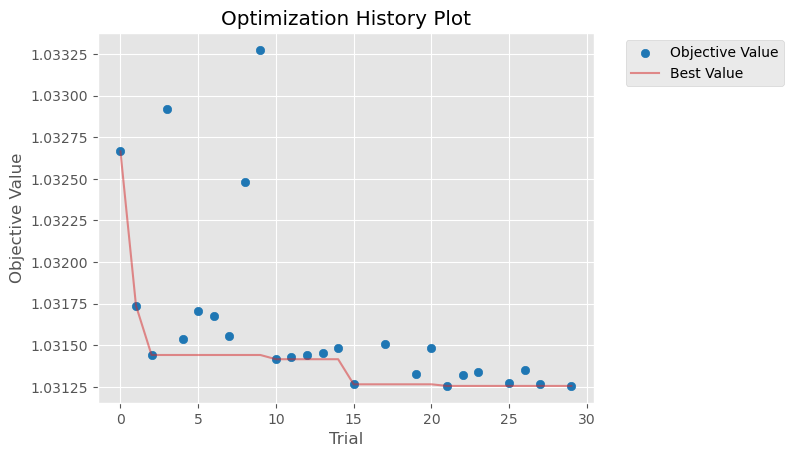

c:\Users\Axyom\Kaggle\PG S4e12 - Regression Insurance\axyom_utilities\hyperparameter_tuning.py:62: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(self.study)


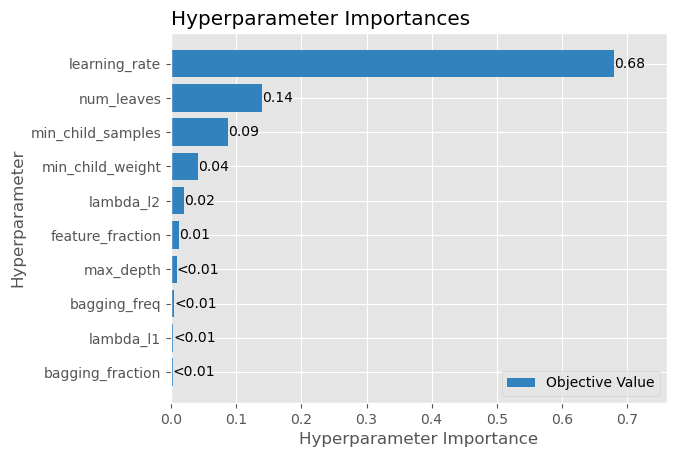

c:\Users\Axyom\Kaggle\PG S4e12 - Regression Insurance\axyom_utilities\hyperparameter_tuning.py:65: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(self.study)


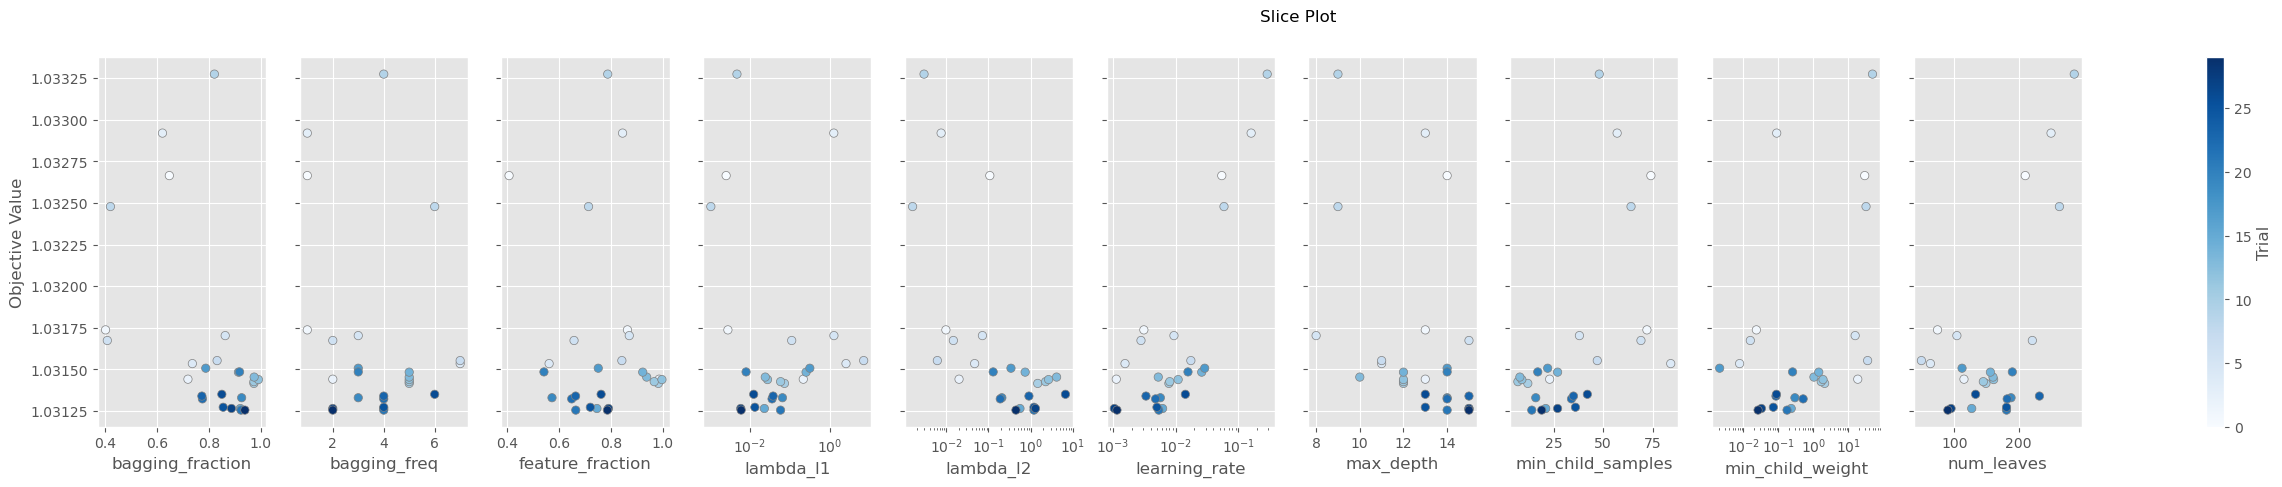

In [30]:
    tuner.plot()


In [31]:
best_params

{'n_estimators': 10000,
 'objective': 'regression',
 'metric': 'rmse',
 'device': 'gpu',
 'verbose': -1,
 'max_bin': 255,
 'learning_rate': 0.00541054326574012,
 'max_depth': 14,
 'num_leaves': 181,
 'min_child_samples': 14,
 'min_child_weight': 0.1795016955095161,
 'feature_fraction': 0.66509582903994,
 'bagging_fraction': 0.9237450162563361,
 'bagging_freq': 4,
 'lambda_l1': 0.058184425474809336,
 'lambda_l2': 1.2000387041285878,
 'n_iterators': 10000}

In [32]:
best_params["n_iterators"] = 10000

# Model Training

In [ ]:
import json
from axyom_utilities.wrappers import LGBMRegressorWrapper

model = LGBMRegressorWrapper(**best_params)

# Use the train_model function to train and evaluate the model
results = train_model_cv(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    X_orig=X_orig,
    early_stopping_rounds=100,
    cv_splits=5
)

In [26]:
# models = results['models']

# # Get feature importance
# feature_importances = models[3].catboost_model_.get_feature_importance(type='PredictionValuesChange')

# # Map to feature names
# feature_importance_df = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Importance': feature_importances
# }).sort_values(by='Importance', ascending=False)

# print(feature_importance_df)

In [27]:
mean_score = np.mean(results["cv_scores"])
std_score = np.std(results["cv_scores"])

# Saving

In [28]:
import json
from pathlib import Path

results_dir = Path(f"{mean_score:.4f}+-{std_score:.4f}")
os.makedirs(results_dir, exist_ok=True)

# Save OOF predictions as a CSV file
oof_preds_df = pd.DataFrame({"oof_preds": results["oof_preds"]})
oof_preds_df.to_csv(results_dir/"oof_preds.csv", index=False)

test_preds_df = pd.DataFrame({"test_preds": results["test_preds"]})
test_preds_df.to_csv(results_dir/"test_preds.csv", index=False)

with open(results_dir/"best_params", "w") as f:
    json.dump(best_params, f, indent=4)

#joblib.dump(results["models"], "models.pkl")

# Submission

In [35]:
y_pred = np.expm1(results['test_preds'])

submission = pd.DataFrame({
    'id': X_test.index,  
    'Premium Amount': y_pred
})

FILE_PATH = os.path.join(results_dir, f"LGBM_v2_{mean_score:.4f}+-{std_score:.4f}.csv")

submission.to_csv(FILE_PATH, index=False)

In [ ]:
if False: 
    # Define your message and file paths
    COMP_NAME = "playground-series-s4e12"

    SUBMIT_MESSAGE = "{mean_score:.4f}+-{std_score:.4f}"

    # Submit to Kaggle
    os.system(f'kaggle competitions submit -c {COMP_NAME} -f {FILE_PATH} -m "{SUBMIT_MESSAGE}"')